In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
csv_drought = 'data/droughts/wsh_p40_droughts.csv'
csv_ba_table = 'data/EIA930_Reference_Tables.csv'
csv_ba_center = 'data/ba-centroids.csv'
col_region = 'Region/Country Name'
region_order = ['California', 'Northwest', 'Southwest', 'Central', 'Midwest', 'Texas', 'New England', 'New York', 'Mid-Atlantic', 'Tennessee', 'Carolinas', 'Southeast', 'Florida']
region_map = {'California': 'Western', 'Northwest': 'Western', 'Southwest': 'Western', 'Central': 'Eastern', 'Midwest': 'Eastern', 'Texas': 'Texas', 'New England': 'Eastern', 'New York': 'Eastern', 'Mid-Atlantic': 'Eastern', 'Tennessee': 'Eastern', 'Carolinas': 'Eastern', 'Southeast': 'Eastern', 'Florida': 'Eastern'}

csv_ba_center = 'data/ba-centroids-rev.csv'
csv_data_ws = 'data/ba_solar_wind_load_monthly_1980_2019.csv'
csv_data_h = 'data/godeeep-hydro-historical-monthly.csv'
csv_data_h_meta = 'data/godeeep-hydro-plants.csv'

# check reference datasets
df_ba_center = pd.read_csv(csv_ba_center, index_col = 0)
df_data_ws = pd.read_csv(csv_data_ws)
data_h_meta = pd.read_csv(csv_data_h_meta).set_index('eia_id').drop('plant', axis=1)
df_data_h = pd.read_csv(csv_data_h, parse_dates = ['datetime']).set_index('eia_id').join(data_h_meta, how='left')

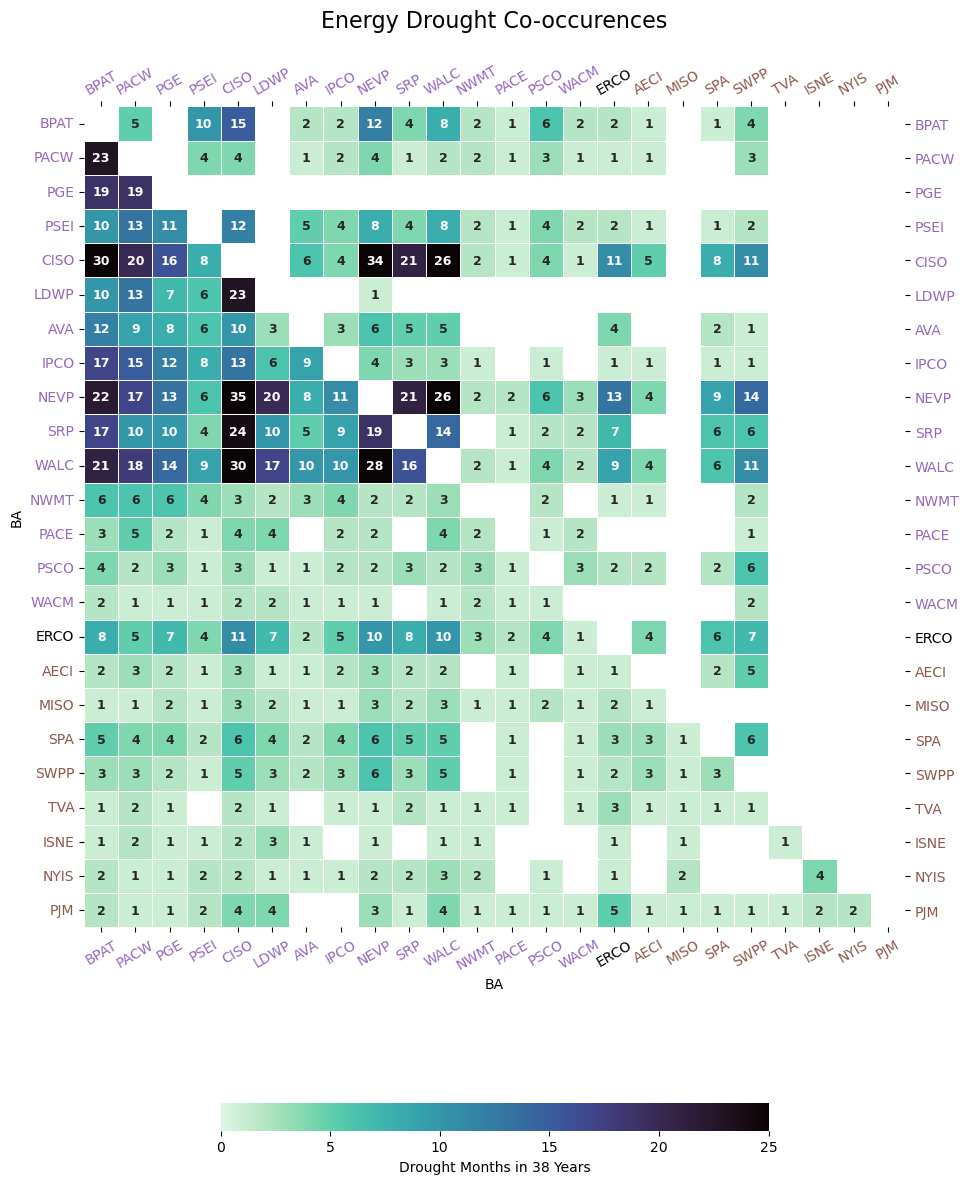

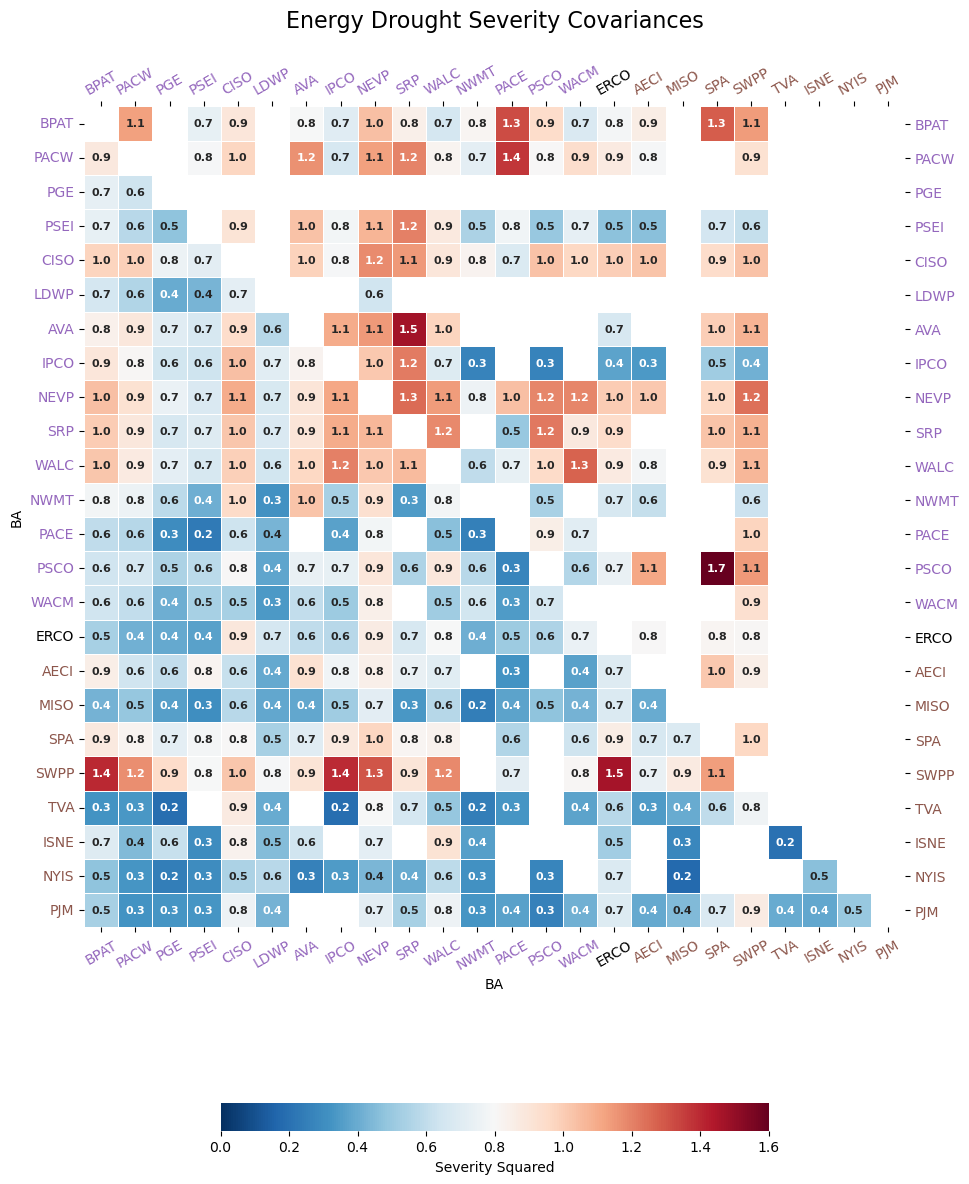

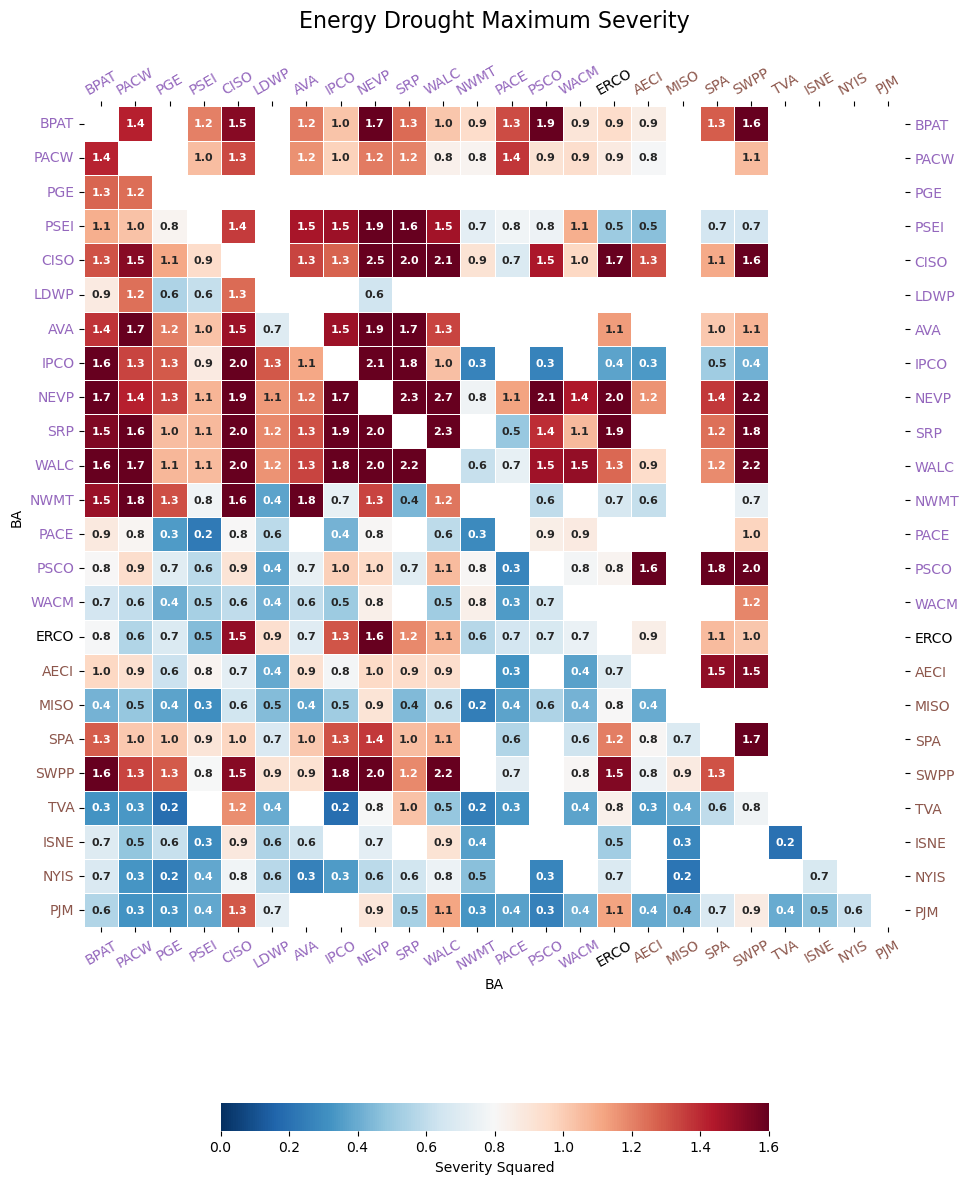

In [18]:

# identify BAs not qualified (missing either electricity source)
df_data_ws = df_data_ws[np.isfinite(df_data_ws['solar_num_sites']) & np.isfinite(df_data_ws['wind_num_sites'])]
ba_wsh = np.intersect1d(df_data_ws['ba'].unique().astype(str), df_data_h['ba'].unique().astype(str))
ba_x = np.setdiff1d(df_ba_center.index, ba_wsh)
#print(f'BAs with all electricity sources: {ba_wsh}')
#print(f'BAs missing either electricity source: {ba_x}')
#print(f'BAs with no location: {np.setdiff1d(ba_wsh, df_ba_center.index)}')

# read a drought dataset
df_drought = pd.read_csv(csv_drought)
df_drought.index = pd.to_datetime(df_drought['datetime_utc'])
df_drought = df_drought.drop(columns = 'datetime_utc')

# merge BA lons/lats
df_ba_table = pd.read_csv(csv_ba_table, index_col = 0)
df_ba_table['Interconnection'] = df_ba_table[col_region].map(region_map)
df_drought = df_drought.merge(df_ba_table, how = 'inner', left_on = 'ba', right_index = True)
#print(df_ba_table.loc[ba_wsh, col_region].groupby(by = df_ba_table.loc[ba_wsh, col_region]).count())
df_drought = df_drought.merge(df_ba_center, how = 'inner', left_on = 'ba', right_index = True)

# expand energy drought events by duration
# comment out if double-counting one single event
for idx, df in df_drought.copy().iterrows():
    for i in range(1, df['drought_duration']):
        df_iter = df_drought.loc[df_drought['ba'] == df['ba']].loc[[idx], :]
        df_iter.index = pd.DatetimeIndex([idx + pd.offsets.MonthBegin(i)], name = 'datetime_utc')
        df_drought = pd.concat([df_drought, df_iter])
df_drought = df_drought.sort_values(['ba', 'drought_id'])

# process co-occurences sum and severity covariance
df_drought_tbl = df_drought.pivot_table(values = 'severity_hws', index = 'datetime_utc', columns = 'ba')
df_drought_tbl = df_drought_tbl.reindex(pd.date_range(start = pd.to_datetime('01/01/1982').tz_localize('UTC'), end = pd.to_datetime('12/31/2019').tz_localize('UTC'), freq = 'MS'))

# select columns of interest
#col_sort = []
#for r in region_order:
#    col_sort = col_sort + df_drought.loc[df_drought[col_region] == r, 'ba'].unique().tolist()
#col_sort = ['PSEI', 'BPAT', 'PGE', 'PACW', 'CISO', 'LDWP', 'AVA', 'IPCO', 'NEVP', 'WALC', 'SRP', 'NWMT', 'PACE', 'WACM', 'PSCO', 'SWPP', 'SPA', 'AECI', 'ERCO', 'MISO', 'TVA', 'PJM', 'NYIS', 'ISNE']
col_sort = ['BPAT', 'PACW', 'PGE', 'PSEI', 'CISO', 'LDWP', 'AVA', 'IPCO', 'NEVP', 'SRP', 'WALC', 'NWMT', 'PACE', 'PSCO', 'WACM', 'ERCO', 'AECI', 'MISO', 'SPA', 'SWPP', 'TVA', 'ISNE', 'NYIS', 'PJM']

# iterate over seasons
#seasons = {'Winter: DJF': [12, 1, 2], 'Spring: MAM': [3, 4, 5], 'Summer: JJA': [6, 7, 8], 'Fall: SON': [9, 10, 11]}
seasons = {'Winter: DJF': [12, 1, 2], 'Fall: SON': [9, 10, 11]}
ba_cooccur_sum, ba_cooccur_weighted, ba_cooccur_max = [], [], []
def max_cooccur(df):
    arr = np.full((len(df.columns), len(df.columns)), np.nan)
    for i, c1 in enumerate(df.columns):
        for j, c2 in enumerate(df.columns):
            val = max(df[c1] * df[c2])
            if np.isfinite(val): arr[i, j] = val
    return pd.DataFrame(arr, index = df.columns, columns = df.columns)

for season, months in seasons.items():
    df_drought_sel = df_drought_tbl.loc[df_drought_tbl.index.month.isin(months)]

    ba_cooccur_sum_all = np.isfinite(df_drought_sel).astype(int).T @ np.isfinite(df_drought_sel).astype(int)
    ba_cooccur_sum_all = ba_cooccur_sum_all.where(ba_cooccur_sum_all > 0, -1)
    ba_cooccur_sum_all.index.name, ba_cooccur_sum_all.columns.name = 'BA', 'BA'
    ba_cooccur_weighted_all = df_drought_sel.fillna(0).T @ df_drought_sel.fillna(0)
    
    ba_cooccur_sum.append(ba_cooccur_sum_all.loc[col_sort, col_sort])
    ba_cooccur_weighted.append(ba_cooccur_weighted_all.loc[col_sort, col_sort])

    ba_cooccur_max.append(max_cooccur(df = df_drought_sel.fillna(0)).loc[col_sort, col_sort])

ba_cooccur_sum_ul = pd.DataFrame(np.triu(ba_cooccur_sum[0], k = 1) + np.tril(ba_cooccur_sum[1], k = -1), index = col_sort, columns = col_sort)
ba_cooccur_weighted_ul = pd.DataFrame(np.triu(ba_cooccur_weighted[0], k = 1) + np.tril(ba_cooccur_weighted[1], k = -1), index = col_sort, columns = col_sort)
ba_cooccur_max_ul = pd.DataFrame(np.triu(ba_cooccur_max[0], k = 1) + np.tril(ba_cooccur_max[1], k = -1), index = col_sort, columns = col_sort)
ba_cooccur_sum_ul.index.name, ba_cooccur_sum_ul.columns.name = 'BA', 'BA'
ba_cooccur_weighted_ul.index.name, ba_cooccur_weighted_ul.columns.name = 'BA', 'BA'
ba_cooccur_max_ul.index.name, ba_cooccur_max_ul.columns.name = 'BA', 'BA'

# draw a heatmap with the numeric values in each cell
fig, ax = plt.subplots(figsize = (14, 13))
hm = sns.heatmap(ba_cooccur_sum_ul, mask = np.identity(len(ba_cooccur_sum_ul), dtype = int) + (ba_cooccur_sum_ul < 0).astype(int), vmin = 0, vmax = 25, center = 12.5, cmap = sns.color_palette('mako_r', as_cmap = True), cbar_kws = {'orientation': 'horizontal', 'shrink': 0.4, 'label': 'Drought Months in 38 Years'}, annot = True, fmt = '.0f', annot_kws = {'size': 9, 'weight': 'bold'}, square = True, linewidths = 0.5, ax = ax)
ax.set_title(f'Energy Drought Co-occurences\n', fontsize = 16)#: {csv_drought}')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, horizontalalignment = 'center');
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0);
ax.tick_params(right = True, labelright = True, top = True, labeltop = True)
for ticklabel in hm.axes.get_xticklabels():
    if df_ba_table.loc[ticklabel.get_text(), 'Interconnection'] == 'Western': ticklabel.set_color('tab:purple')
    elif df_ba_table.loc[ticklabel.get_text(), 'Interconnection'] == 'Eastern': ticklabel.set_color('tab:brown')
    else: ticklabel.set_color('black')
for ticklabel in hm.axes.get_yticklabels():
    if df_ba_table.loc[ticklabel.get_text(), 'Interconnection'] == 'Western': ticklabel.set_color('tab:purple')
    elif df_ba_table.loc[ticklabel.get_text(), 'Interconnection'] == 'Eastern': ticklabel.set_color('tab:brown')
    else: ticklabel.set_color('black')
plt.tight_layout()
plt.savefig(f'figures/FIGURE02b.png', bbox_inches = 'tight', dpi = 300)

# draw a heatmap with the numeric values in each cell
fig, ax = plt.subplots(figsize = (14, 13))
hm = sns.heatmap(ba_cooccur_weighted_ul / ba_cooccur_sum_ul, mask = np.identity(len(ba_cooccur_weighted_ul), dtype = int) + (ba_cooccur_sum_ul < 0).astype(int), vmin = 0, vmax = 1.6, center = 0.8, cmap = sns.color_palette('RdBu_r', as_cmap = True), cbar_kws = {'orientation': 'horizontal', 'shrink': 0.4, 'label': 'Severity Squared'}, annot = True, fmt = '.1f', annot_kws = {'size': 8, 'weight': 'bold'}, square = True, linewidths = 0.5, ax = ax)
ax.set_title(f'Energy Drought Severity Covariances\n', fontsize = 16)#: {csv_drought}')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, horizontalalignment = 'center');
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0);
ax.tick_params(right = True, labelright = True, top = True, labeltop = True)
for ticklabel in hm.axes.get_xticklabels():
    if df_ba_table.loc[ticklabel.get_text(), 'Interconnection'] == 'Western': ticklabel.set_color('tab:purple')
    elif df_ba_table.loc[ticklabel.get_text(), 'Interconnection'] == 'Eastern': ticklabel.set_color('tab:brown')
    else: ticklabel.set_color('black')
for ticklabel in hm.axes.get_yticklabels():
    if df_ba_table.loc[ticklabel.get_text(), 'Interconnection'] == 'Western': ticklabel.set_color('tab:purple')
    elif df_ba_table.loc[ticklabel.get_text(), 'Interconnection'] == 'Eastern': ticklabel.set_color('tab:brown')
    else: ticklabel.set_color('black')
plt.tight_layout()
plt.savefig(f'figures/FIGURE02c.png', bbox_inches = 'tight', dpi = 300)

# draw a heatmap with the numeric values in each cell
fig, ax = plt.subplots(figsize = (14, 13))
hm = sns.heatmap(ba_cooccur_max_ul, mask = np.identity(len(ba_cooccur_max_ul), dtype = int) + (ba_cooccur_sum_ul < 0).astype(int), vmin = 0, vmax = 1.6, center = 0.8, cmap = sns.color_palette('RdBu_r', as_cmap = True), cbar_kws = {'orientation': 'horizontal', 'shrink': 0.4, 'label': 'Severity Squared'}, annot = True, fmt = '.1f', annot_kws = {'size': 8, 'weight': 'bold'}, square = True, linewidths = 0.5, ax = ax)
ax.set_title(f'Energy Drought Maximum Severity\n', fontsize = 16)#: {csv_drought}')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, horizontalalignment = 'center');
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0);
ax.tick_params(right = True, labelright = True, top = True, labeltop = True)
for ticklabel in hm.axes.get_xticklabels():
    if df_ba_table.loc[ticklabel.get_text(), 'Interconnection'] == 'Western': ticklabel.set_color('tab:purple')
    elif df_ba_table.loc[ticklabel.get_text(), 'Interconnection'] == 'Eastern': ticklabel.set_color('tab:brown')
    else: ticklabel.set_color('black')
for ticklabel in hm.axes.get_yticklabels():
    if df_ba_table.loc[ticklabel.get_text(), 'Interconnection'] == 'Western': ticklabel.set_color('tab:purple')
    elif df_ba_table.loc[ticklabel.get_text(), 'Interconnection'] == 'Eastern': ticklabel.set_color('tab:brown')
    else: ticklabel.set_color('black')
plt.tight_layout()
#plt.savefig(f'FIGURE02d.png', bbox_inches = 'tight', dpi = 300)